## Download Data

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download dschettler8845/brats-2021-task1

100% 12.3G/12.3G [11:03<00:00, 18.4MB/s]
100% 12.3G/12.3G [11:03<00:00, 19.9MB/s]


In [6]:
! unzip "/content/brats-2021-task1.zip"

Archive:  /content/brats-2021-task1.zip
  inflating: BraTS2021_00495.tar     
  inflating: BraTS2021_00621.tar     
  inflating: BraTS2021_Training_Data.tar  


In [10]:
fname =  "/content/BraTS2021_Training_Data.tar"

import tarfile

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

## Load Data

In [ ]:
! pip install monai
! pip install torchsummary


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
# from monai.networks.nets import VNet
# from monai.metrics import DiceMetric
# from monai.losses import DiceLoss
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm
from torchsummary import summary
import nibabel as nib
import gzip



In [ ]:
class BraTSDataset(Dataset):

    def __init__(self, path, transform=None):
        """
        Args:
            images_path (string): Path to input images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path
        self.transform = transform
        self.cases_list = os.listdir(path)



    def __len__(self):
        return len(self.cases_list)

    def __getitem__(self, idx):
        image_name = self.cases_list[idx]
        
        image_path = self.path + "/" + image_name +"/" +image_name + "_t1.nii"
        image =  nib.load(image_path)
        image = image.get_fdata()
        min_ = image.min()
        max_ = image.max()
        image = (image - min_)/(max_ - min_)
        image = np.float32(image)
        # image = np.expand_dims(image, axis = -1)
        #--------------------------------------------------
        mask_path = self.path + "/" + image_name +"/" + image_name + "_seg.nii"
        mask =  nib.load(mask_path)
        mask = mask.get_fdata()
        min_ = mask.min()
        max_ = mask.max()
        mask = (mask - min_)/(max_ - min_)
        mask = np.float32(mask)
        # mask = np.expand_dims(mask, axis = -1)


        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w, z = image.shape[:3]
        
        new_h, new_w, new_z = self.output_size

        new_h, new_w, new_z = int(new_h), int(new_w), int(new_z)

        img = transform.resize(image, (new_h, new_w, new_z))
        mask = transform.resize(mask, (new_h, new_w, new_z))
        # img = np.stack((img,)*3, axis=-1)

        return {'image': img, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

In [ ]:
train = BraTSDataset(path='/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData',
                                    transform=transforms.Compose([
                                        # Rescale((256,256,128)),
                                        ToTensor()
                                           ]))


val = BraTSDataset(path='/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData',
                                    transform=transforms.Compose([
                                        # Rescale((256,256,128)),
                                        ToTensor()
                                           ]))


sample = train[3]
# print(sample)
print(sample['image'].shape, sample['mask'].shape)


torch.Size([155, 240, 240]) torch.Size([155, 240, 240])


In [ ]:
print(len(train))
print(len(val))

371
127


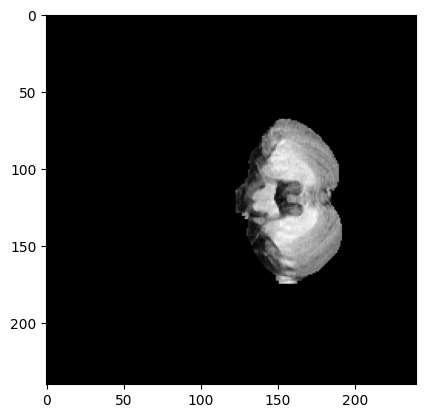

In [ ]:
sample = train[50]
plt.imshow(sample['image'][20,:,:], cmap = "gray")

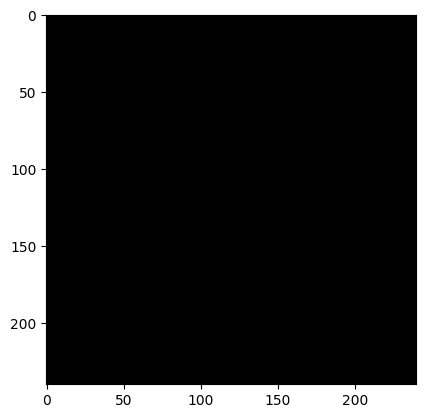

In [ ]:
plt.imshow(sample['mask'][20,:,:], cmap = "gray")

In [ ]:
train_loader = DataLoader(train, batch_size=4,
                        shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=4,
                        shuffle=True, num_workers=0)

In [ ]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['mask'].size())
    if i_batch == 2: break

0 torch.Size([4, 155, 240, 240]) torch.Size([4, 155, 240, 240])
1 torch.Size([4, 155, 240, 240]) torch.Size([4, 155, 240, 240])
2 torch.Size([4, 155, 240, 240]) torch.Size([4, 155, 240, 240])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Model

In [ ]:
vnet = VNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
)
model = torch.nn.Sequential(
    vnet,
    torch.nn.Sigmoid()
).to(device)


# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)


In [ ]:
summary(model, input_size=(1, 512, 512))

In [ ]:
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience= 5)


In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm(enumerate(train_loader), unit="batch", total=len(train_loader)):
        # Every data instance is an input + label pair
        inputs  = data["image"].to(device)
        labels = data["mask"].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i  == len(train_loader)-1:
            last_loss = running_loss / len(train_loader) # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/content/out/cbct_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 20

best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    with torch.no_grad():
      for i, vdata in tqdm(enumerate(val_loader), unit="batch", total=len(val_loader)):
          vinputs = vdata["image"].to(device)
          vlabels = vdata["mask"].to(device)
          voutputs = model(vinputs)
          vloss = loss_function(voutputs, vlabels)
          running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      scheduler.step(avg_vloss)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    torch.save(model, "/content/drive/MyDrive/Dental/weights/test_vnet_2d/"+str(epoch_number)+".h5")
    epoch_number += 1


## Testing SAM

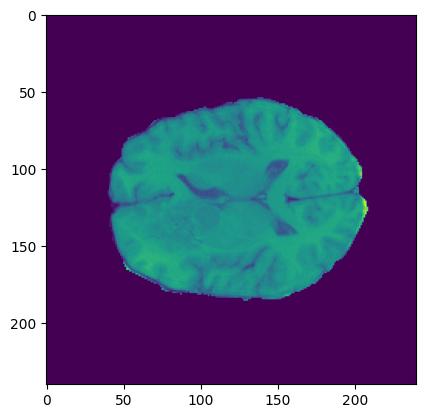

In [32]:
image_path = "/content/BraTS2021_00000/BraTS2021_00000_t1.nii.gz"

image =  nib.load(image_path)
image = image.get_fdata()
min_ = image.min()
max_ = image.max()
image = (image - min_)/(max_ - min_)
image = np.float32(image)

plt.imshow(image[:,:,80])

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [29]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

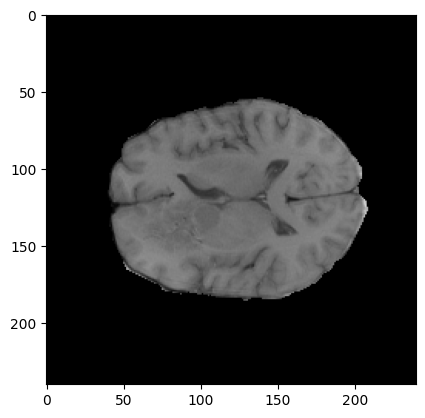

In [33]:
image = cv2.cvtColor(image[:,:,80], cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [38]:
image = image * 255

In [40]:
image = np.uint8(image)

In [36]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [41]:
predictor.set_image(image)

In [34]:
image.shape

(240, 240, 3)

In [35]:
input_box = np.array([0, 0, 240, 240])

In [44]:
masks, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

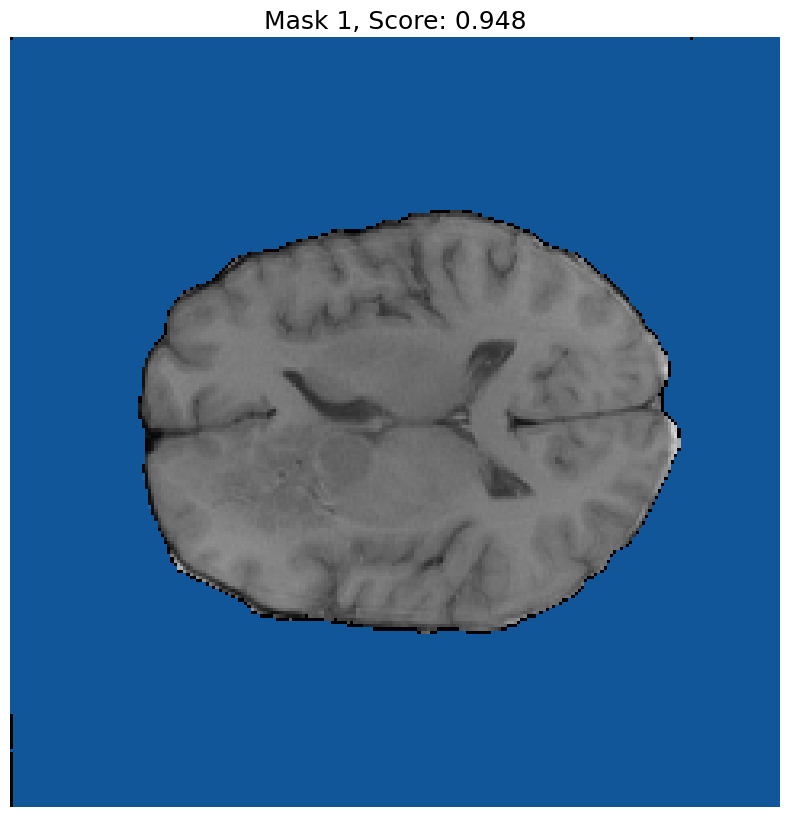

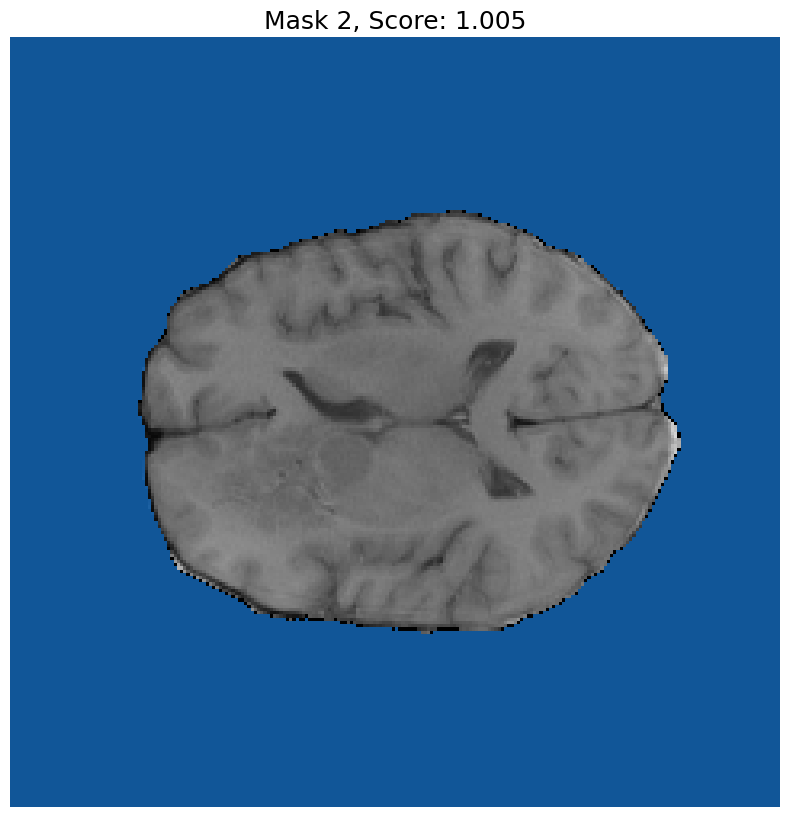

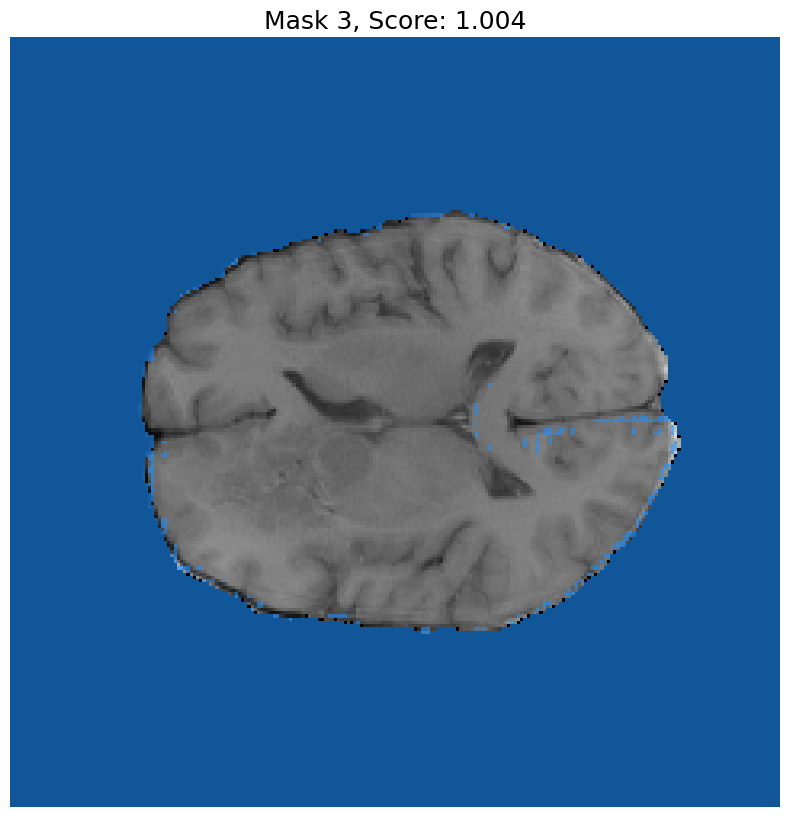

In [46]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  